In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import Lasso, LassoCV, RidgeCV, LinearRegression
import statsmodels.api as sm
from BayesianLasso import BayesianLasso

In [2]:
# Load Dataset

filename = "Data/training_data13x16.pickle"

with open(filename,"rb") as file:
    X_train, y_train = pickle.load(file)
    
X_train.shape, y_train.shape

((13, 16), (13, 1))

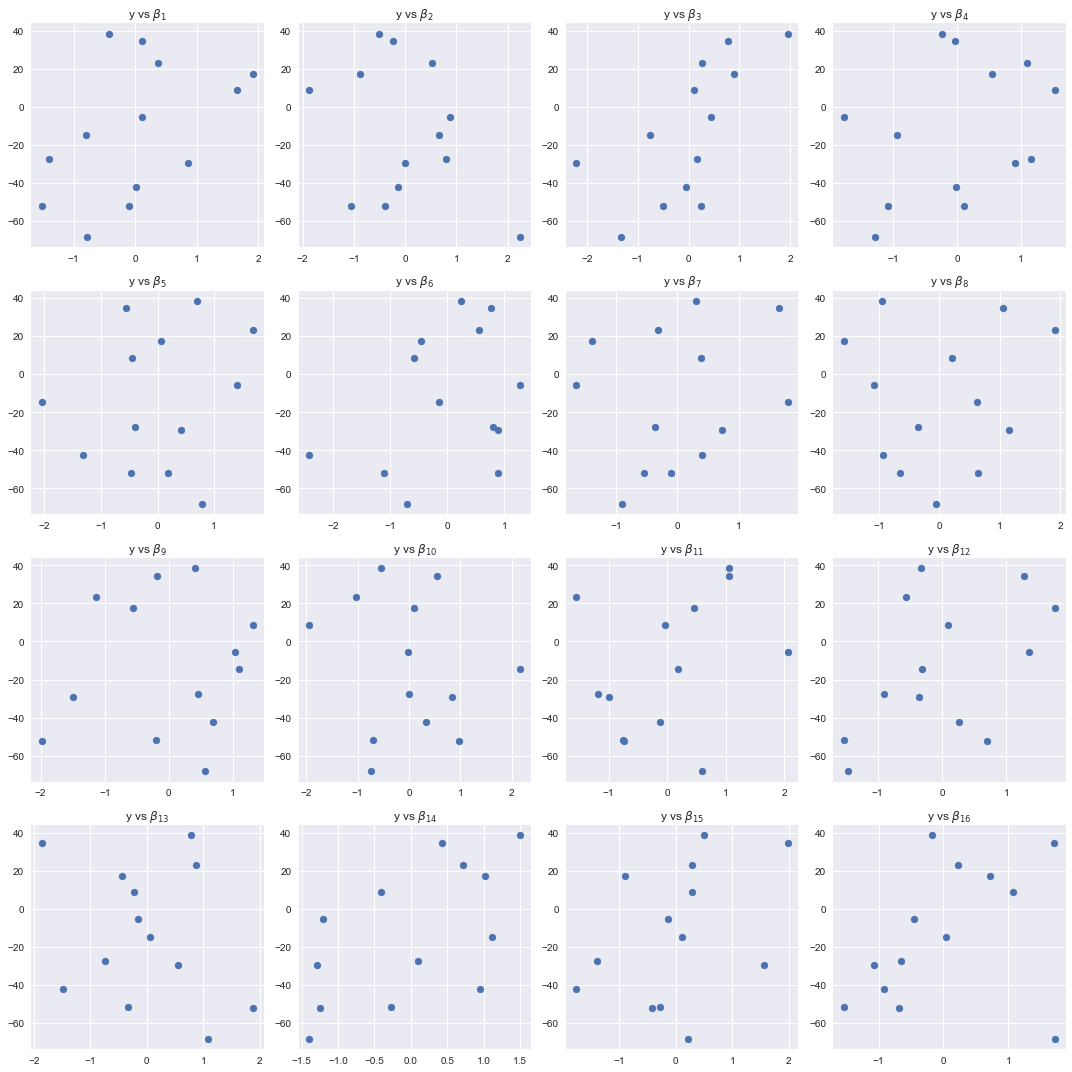

In [3]:
# First make some plots
plt.style.use('seaborn')
X_train = (X_train-np.mean(X_train,axis=0))/np.std(X_train,axis=0)

fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(15,15))
for row in range(1,5):
    for column in range(1,5):
        ax[row-1][column-1].scatter(X_train[:,4*(row-1)+column-1],y_train)
        ax[row-1][column-1].title.set_text(fr"y vs $\beta_{{{4*(row-1)+column}}}$")

plt.tight_layout()
plt.show()
# Looks like potential linear correlations with beta1, beta2, beta 3 from the plot.

In [4]:
# Basic Gibbs Sampler
lam = 1

bayesianLasso = BayesianLasso(X_train,y_train)
beta_samplesLam, sig2_samplesLam, tau2_samplesLam = bayesianLasso.gibbs_fixedLam(lam,10000)

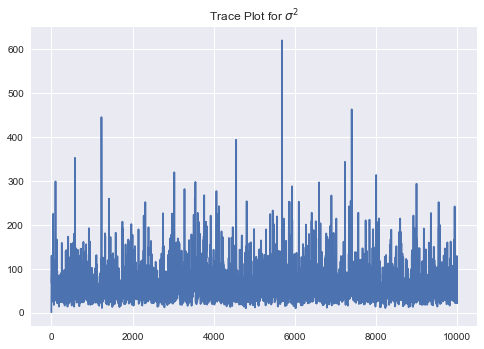

In [5]:
# Trace plot for Sigma^2
plt.style.use('seaborn')
plt.title(r"Trace Plot for $\sigma^{2}$")
plt.plot(sig2_samplesLam)
plt.show()
# A burn in period of 2000 seems sufficient

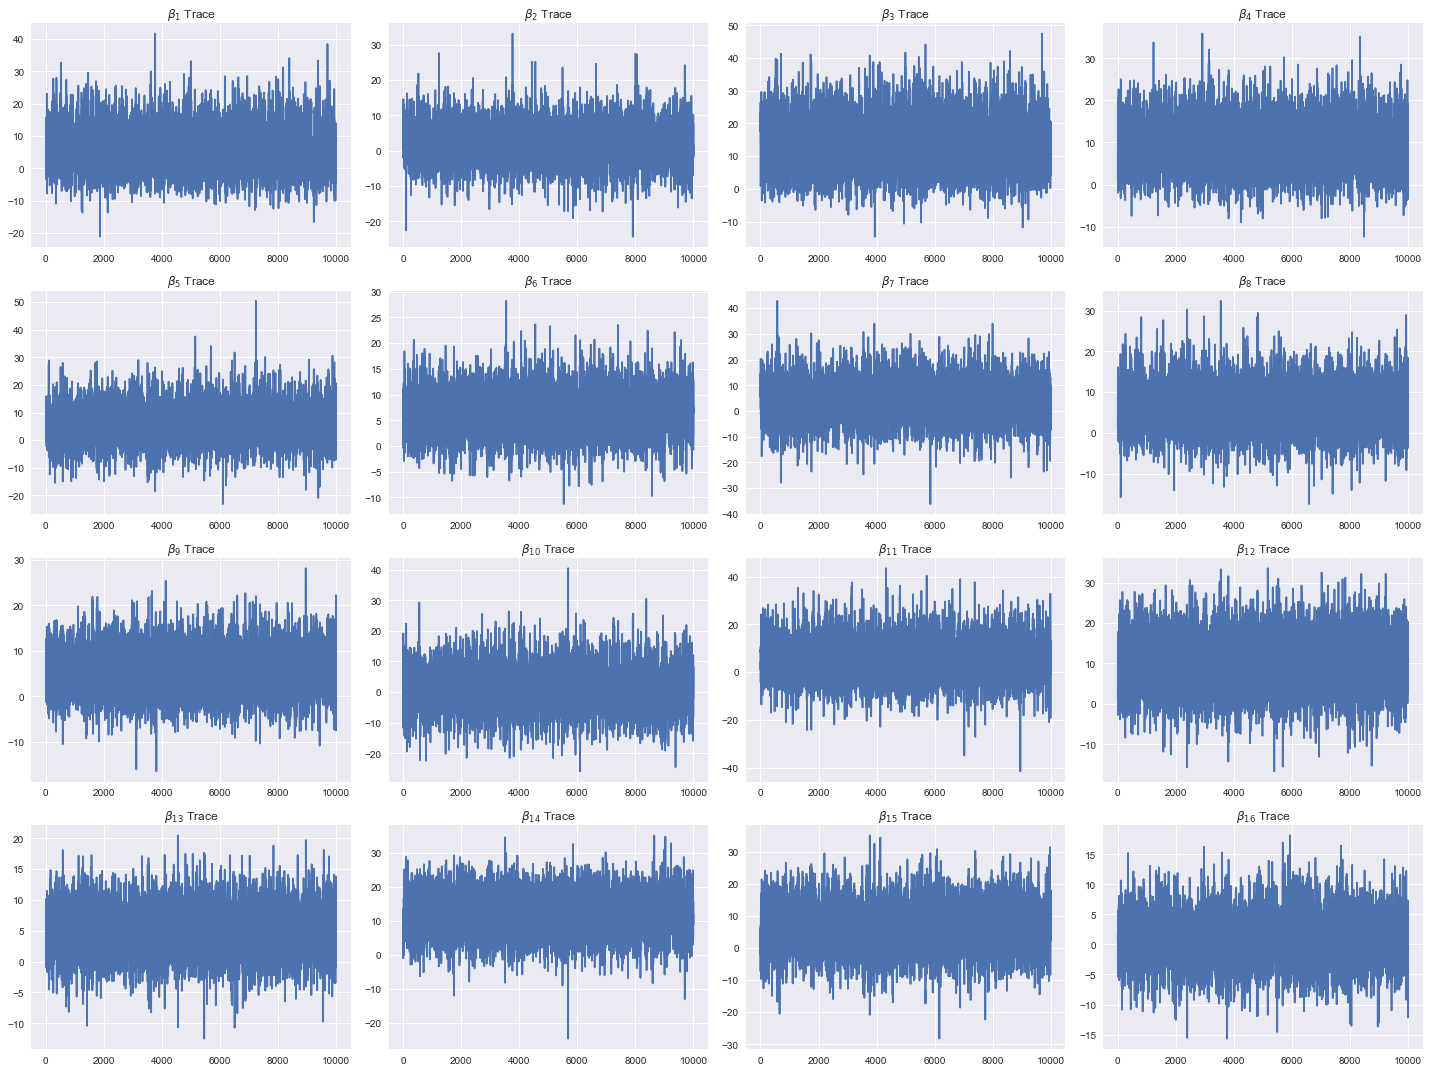

In [6]:
# Trace Plots for the Beta
plt.style.use('seaborn')
fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(20,15))

for row in range(1,5):
    for column in range(1,5):
        ax[row-1][column-1].plot(beta_samplesLam[:,4*(row-1)+column-1])
        ax[row-1][column-1].title.set_text(fr"$\beta_{{{4*(row-1)+column}}}$ Trace")

# Again a burn in of 2000 seems good

plt.tight_layout()
plt.show()

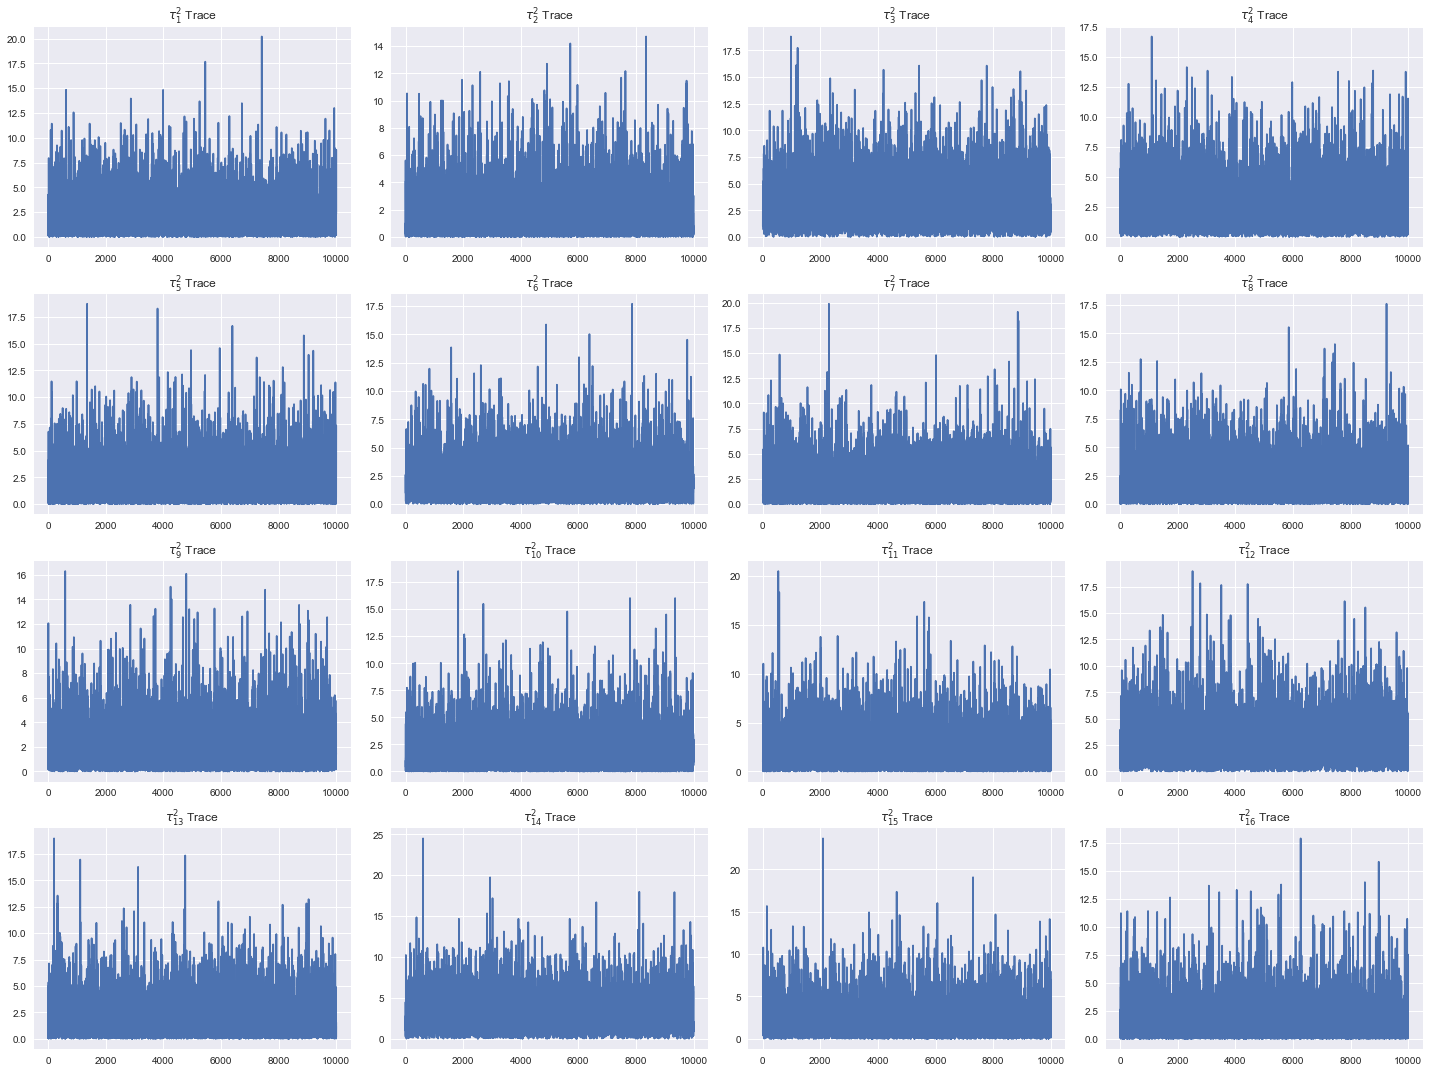

In [7]:
# Trace Plots for the Tau
plt.style.use('seaborn')
fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(20,15))

for row in range(1,5):
    for column in range(1,5):
        ax[row-1][column-1].plot(tau2_samplesLam[:,4*(row-1)+column-1])
        ax[row-1][column-1].title.set_text(fr"$\tau^{2}_{{{4*(row-1)+column}}}$ Trace")

# Again a burn in of 2000 seems good
plt.tight_layout()
plt.show()

In [8]:
burned_beta_tracesLam = beta_samplesLam[2000:,:]
burned_sig2_tracesLam = sig2_samplesLam[2000:]
burned_tau2_tracesLam = tau2_samplesLam[2000:,:]

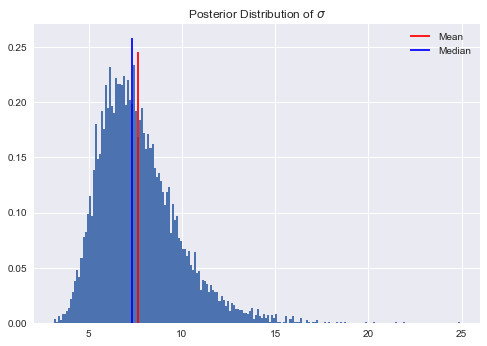

Mean: 7.671659177717016
Median: 7.338779641501231


In [9]:
# Histogram for Sigma^2
plt.style.use('seaborn')
plt.title(r"Posterior Distribution of $\sigma$")
plt.hist(np.sqrt(burned_sig2_tracesLam),bins=200,density=True)
plt.vlines(np.mean(np.sqrt(burned_sig2_tracesLam)),0,plt.gca().get_ylim()[1],colors="r",label="Mean")
plt.vlines(np.median(np.sqrt(burned_sig2_tracesLam)),0,plt.gca().get_ylim()[1],colors="b",label="Median")
plt.legend(loc="upper right")
plt.show()

print(f"Mean: {np.mean(np.sqrt(burned_sig2_tracesLam))}")
print(f"Median: {np.median(np.sqrt(burned_sig2_tracesLam))}")

In [10]:
# I now calculate the frequentist Lasso estimates that SHOULD (theoretically) equal the mode of the posterior distribution
# I check this using scikit and statsmodels

sigmamedian = np.median(np.sqrt(burned_sig2_tracesLam))
sigmamean = np.mean(np.sqrt(burned_sig2_tracesLam))
# Check with SciKit's Lasso 
lassomodel = Lasso(alpha=2*sigmamedian*lam/(2*len(y_train)),fit_intercept=False,tol=1e-10).fit(X_train,y_train-np.mean(y_train))
print(lassomodel.coef_)

# StatsModel's Lasso
smLasso = sm.OLS(y_train-np.mean(y_train),X_train).fit_regularized(alpha=2*sigmamedian*lam/(2*len(y_train)))
print(smLasso.params)

[ 1.48593641  0.          9.90573602  8.2255576   5.46115838  5.35406749
  0.          3.85598555  7.56640676 -0.          0.         13.08062482
  3.96565078 15.11551477 10.99754202  0.3436798 ]
[ 6.64435072  0.23574078 12.62570965  8.1412852   3.90281243  8.6432444
  4.63120558  8.6961059   1.9594165   0.          8.54512217  7.60759711
  4.5282646  11.87882971  0.          1.4139705 ]


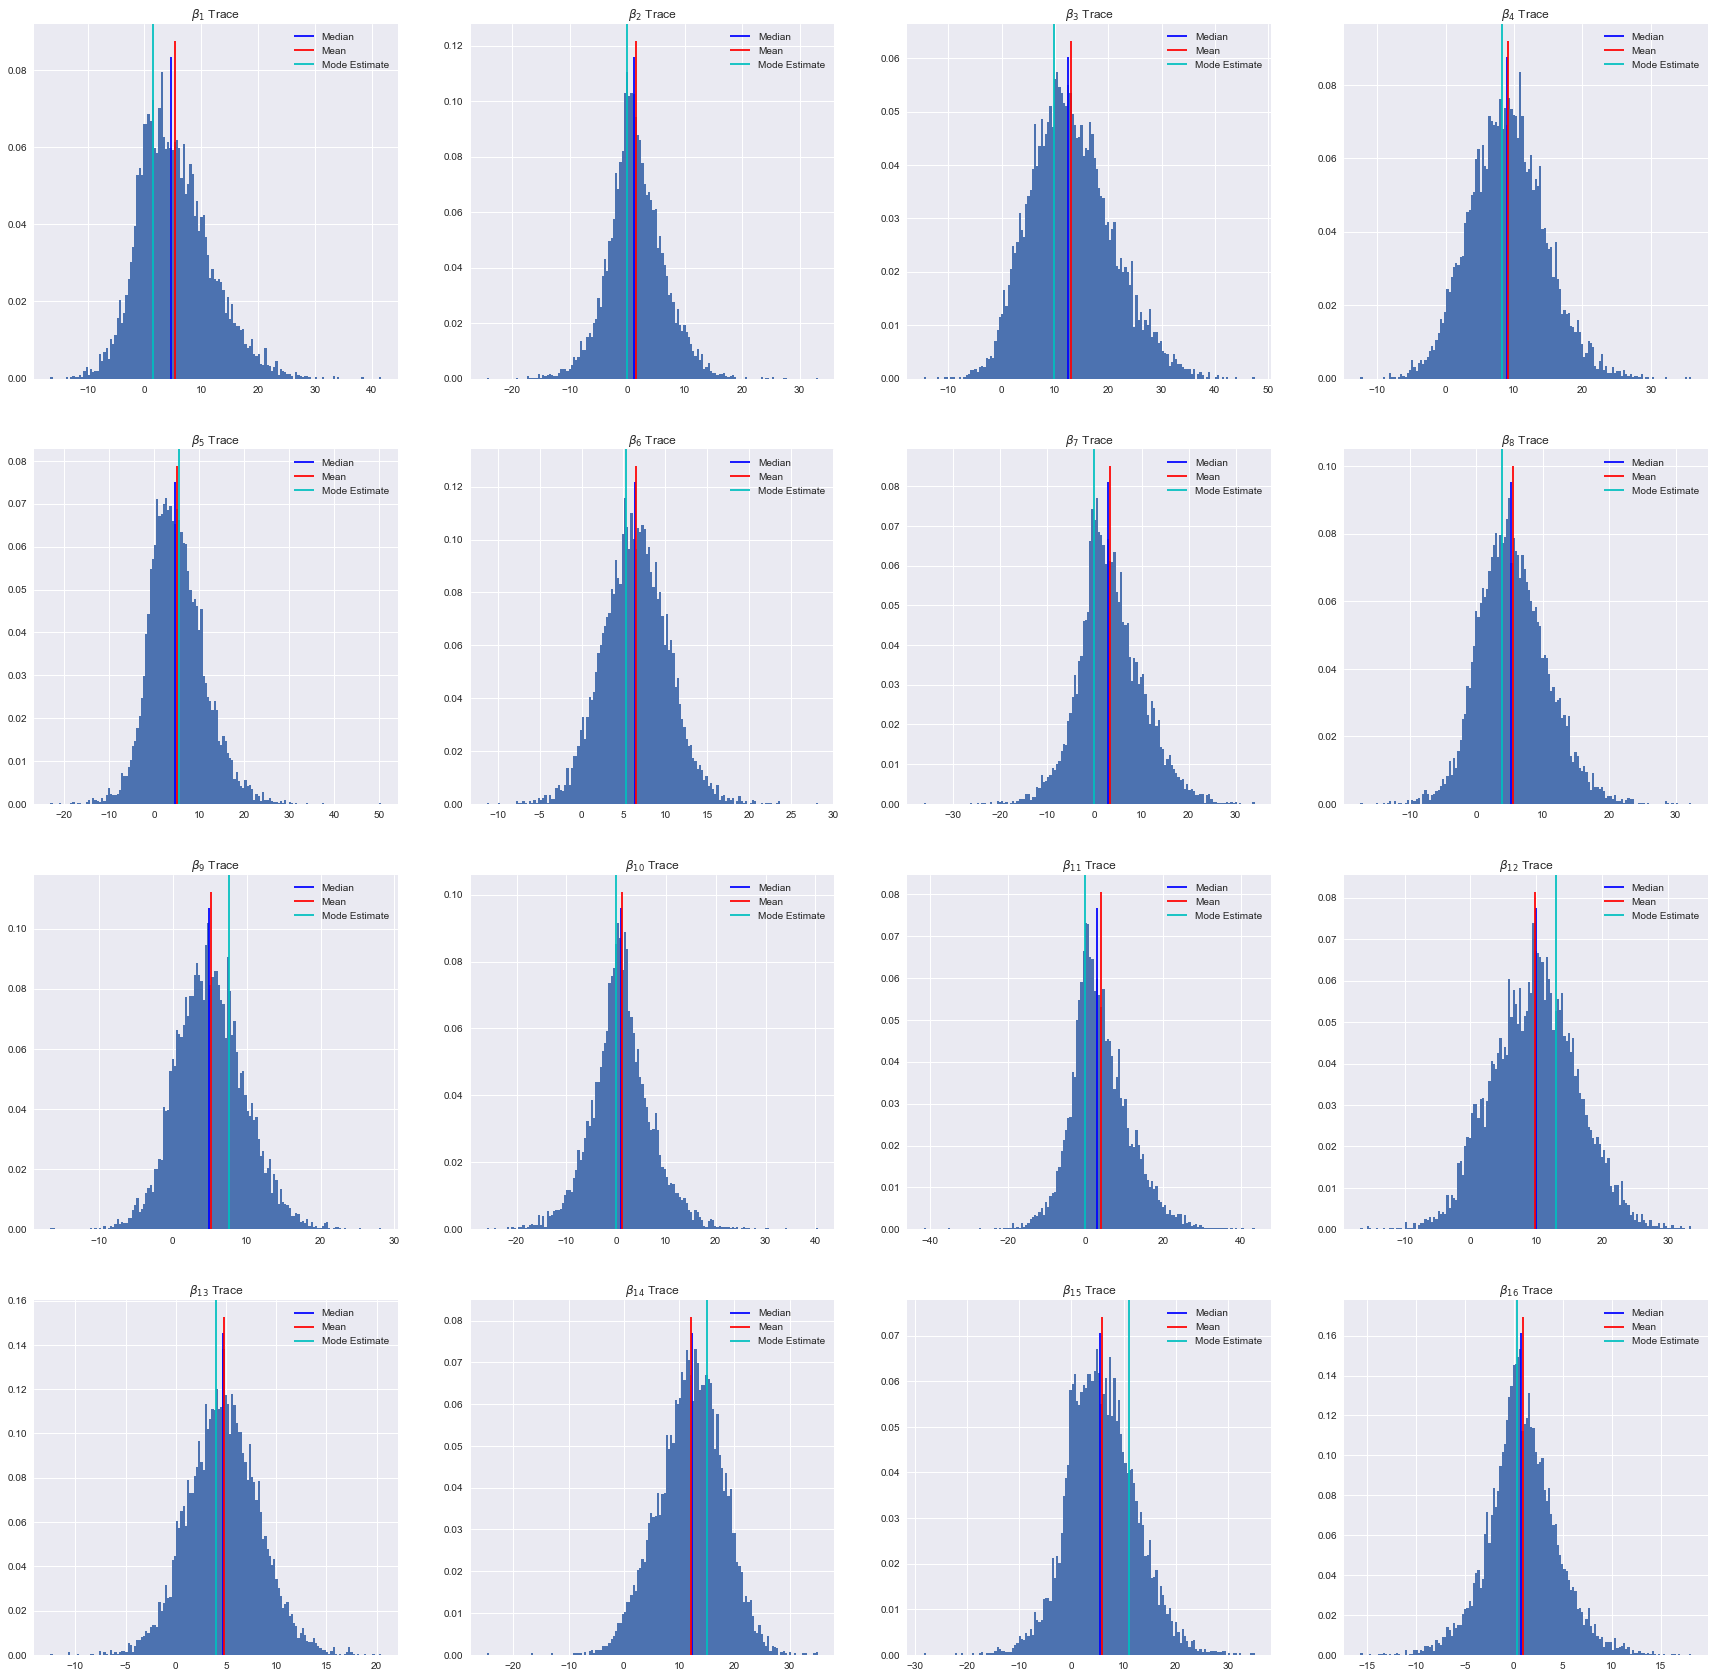

In [11]:
# Trace Plots for the Beta
plt.style.use('seaborn')
fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(30,30))

for row in range(1,5):
    for column in range(1,5):
        ax[row-1][column-1].hist(burned_beta_tracesLam[:,4*(row-1)+column-1],bins=150,density=True)
        ax[row-1][column-1].title.set_text(fr"$\beta_{{{4*(row-1)+column}}}$ Trace")
        ax[row-1][column-1].vlines(np.median(burned_beta_tracesLam,axis=0)[4*(row-1)+column-1],0,ax[row-1][column-1].get_ylim()[1],colors="b",label="Median")
        ax[row-1][column-1].vlines(np.mean(burned_beta_tracesLam,axis=0)[4*(row-1)+column-1],0,ax[row-1][column-1].get_ylim()[1],colors="r",label="Mean")
        ax[row-1][column-1].set_ylim()
        ax[row-1][column-1].vlines(lassomodel.coef_[4*(row-1)+column-1],0,ax[row-1][column-1].get_ylim()[1],colors="c",label="Mode Estimate")
        ax[row-1][column-1].legend()
        
plt.show()

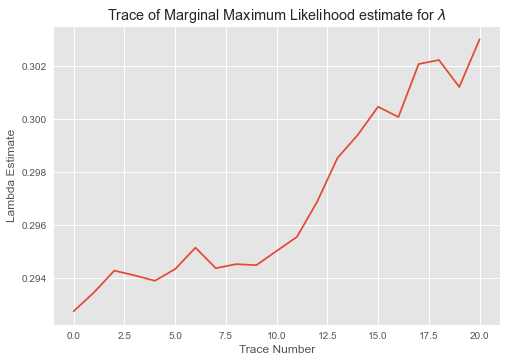

In [13]:
"""Find maximum marginal likelihood estimate for lambda"""
from BayesianLasso import BayesianLasso
bayesianLasso = BayesianLasso(X_train,y_train)
lambdasMML,lambdaMML = bayesianLasso.lambda_MML(em_iter=20,gibbs_iter=10000)
plt.style.use('ggplot')
plt.title(r"Trace of Marginal Maximum Likelihood estimate for $\lambda$")
plt.plot(lambdasMML)
plt.xlabel("Trace Number")
plt.ylabel("Lambda Estimate")

plt.show()

In [30]:
# Run the Gibbs Sampler using this marginal maximum likelihood estimate
betatracesMML,sig2tracesMML,tau2tracesMML = bayesianLasso.gibbs_fixedLam(lambdaMML,30000)

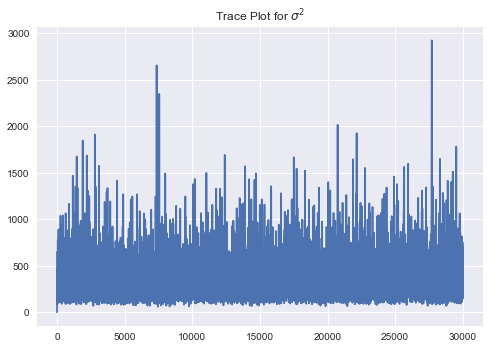

In [36]:
# Trace plot for Sigma^2
plt.style.use("seaborn")
plt.title(r"Trace Plot for $\sigma^{2}$")
plt.plot(sig2tracesMML)
plt.show()
# A burn in period of 1000 seems sufficient

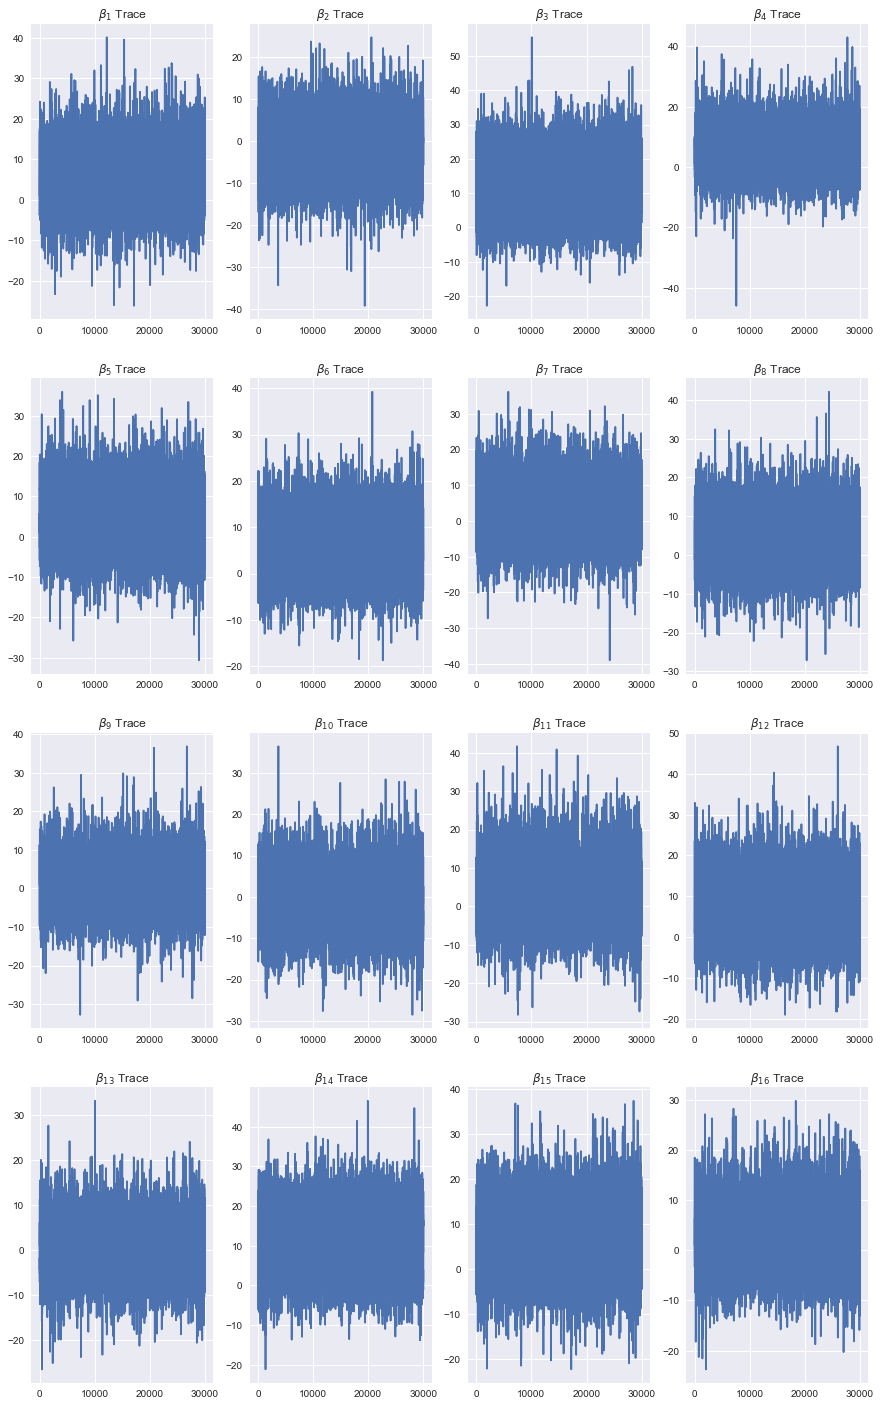

In [37]:
# Trace Plots for the Beta
fig, ax = plt.subplots(nrows=4,ncols=4,figsize=(15,25))

for i in range(1,5):
    for j in range(1,5):
        ax[i-1][j-1].plot(betatracesMML[:,4*(i-1)+j-1])
        ax[i-1][j-1].title.set_text(fr"$\beta_{{{4*(i-1)+j}}}$ Trace")

# Again a burn in of 2000 seems good

In [38]:
burnedbetatracesMML, burnedsig2tracesMML, burnedtau2tracesMML = betatracesMML[5000:,:], sig2tracesMML[5000:], tau2tracesMML[5000:,:]

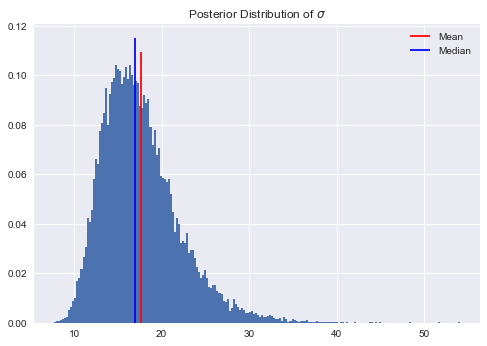

Mean: 17.587863417124996
Median: 16.906794393540217


In [39]:
# Histogram for Sigma^2

plt.title(r"Posterior Distribution of $\sigma$")
plt.hist(np.sqrt(burnedsig2tracesMML),bins=200,density=True)
plt.vlines(np.mean(np.sqrt(burnedsig2tracesMML)),0,plt.gca().get_ylim()[1],colors="r",label="Mean")
plt.vlines(np.median(np.sqrt(burnedsig2tracesMML)),0,plt.gca().get_ylim()[1],colors="b",label="Median")
plt.legend(loc="upper right")
plt.show()

print(f"Mean: {np.mean(np.sqrt(burnedsig2tracesMML))}")
print(f"Median: {np.median(np.sqrt(burnedsig2tracesMML))}")

In [42]:
# I now calculate the frequentist Lasso estimates that SHOULD (theoretically) equal the mode of the posterior distribution
# I check this using scikit and statsmodels

sigmamedian = np.median(np.sqrt(burnedsig2tracesMML))

# Check with SciKit's Lasso 
skMML = Lasso(alpha=2*sigmamedian*lambdaMML/(2*len(y_train)),fit_intercept=False,tol=1e-12)
skMML = skMML.fit(X_train,y_train-np.mean(y_train))
print(skMML.coef_)

# StatsModel's Lasso
smMML = sm.OLS(y_train-np.mean(y_train),X_train).fit_regularized(alpha=2*sigmamedian*lambdaMML/(2*len(y_train)))
print(smMML.params)

[ 6.64556978 -0.         14.0063238   0.84076268  0.          3.67164168
  0.          0.          0.         -0.          0.          1.9297719
 -0.          9.13584986  9.6688179   0.22108326]
[ 7.2485397   0.         14.13336514  0.          0.          3.68299101
  0.          0.02481118  0.          0.          0.          1.53604253
  0.          9.2858711   9.6955002   0.        ]


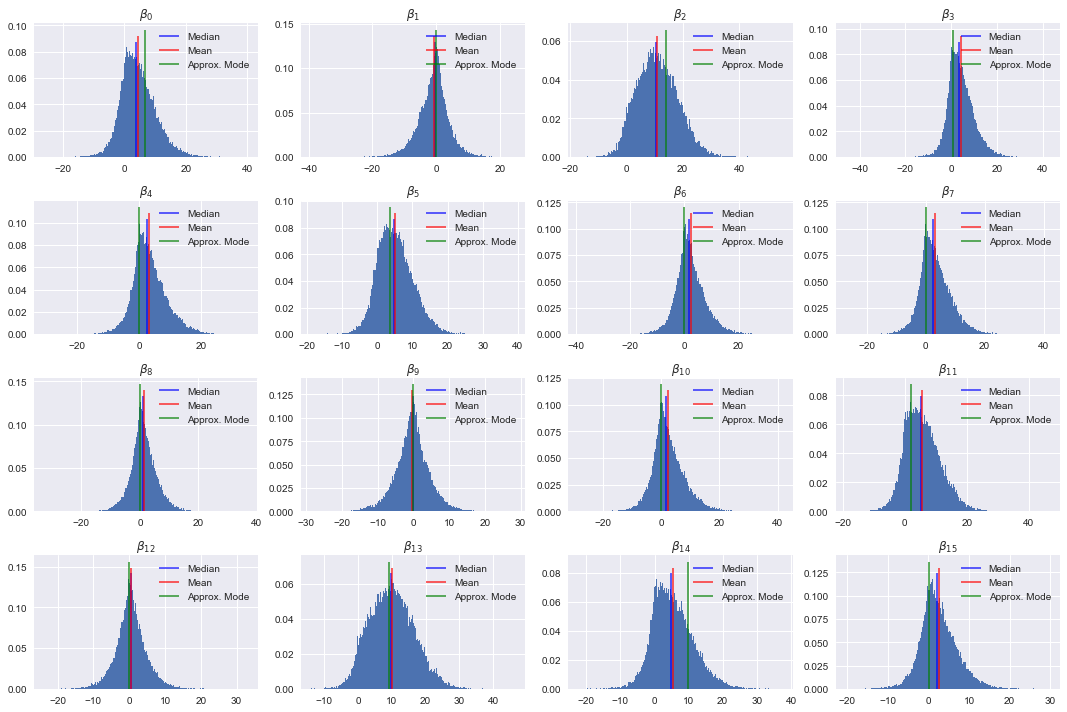

In [49]:
# Histograms for Beta, with medians, means plotted 
# Also plotted the frequentist Lasso estimates that theoretically should be the mode of the posteriors
fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(15,10))

for i in range(1, 5):
    for j in range(1,5):
        ax[i-1][j-1].hist(burnedbetatracesMML[:,4*(i-1) + j-1],bins=200,density=True)
        ax[i-1][j-1].title.set_text(fr"$\beta_{{{4*(i-1) + j-1}}}$")
        ax[i-1][j-1].vlines(np.median(burnedbetatracesMML,axis=0)[4*(i-1) + j-1],0,ax[i-1][j-1].get_ylim()[1],colors="b",label="Median",alpha=0.7)
        ax[i-1][j-1].vlines(np.mean(burnedbetatracesMML,axis=0)[4*(i-1) + j-1],0,ax[i-1][j-1].get_ylim()[1],colors="r",label="Mean",alpha=0.7)
        #ax[i-1][j-1].vlines(skMML.coef_[4*(i-1) + j-1],0,ax[i-1][j-1].get_ylim()[1],colors="g",label="Approx. Mode",alpha=0.7)
        ax[i-1][j-1].set_ylim()
        ax[i-1][j-1].legend(loc="upper right")
        
plt.tight_layout()
plt.show()

# The symmetric distributions mean that the mode, mean and medians are really close
# But it does look like the frequentist estimates match the empirical mode of the posteriors.

In [84]:
"""Make regularisation plots"""

lambdas = np.linspace(0.1,400,400)
lambdaBetaMedians = np.zeros((len(lambdas),16)) # Matrix of (lambda,posterior medians)
lambdaBetaMeans = np.zeros((len(lambdas),16)) # Matrix of (lambda,posterior means)

for idx, lam in enumerate(lambdas):
    betaTraces, sig2Traces, tau2Traces = bayesianLasso.gibbs_fixedLam(lam,n_iter=10000)
    burnedBetaTraces = betaTraces[2000:,:]
    lambdaBetaMedians[idx,:] = np.reshape(np.median(burnedBetaTraces,axis=0),(1,-1))
    lambdaBetaMeans[idx,:] = np.reshape(np.mean(burnedBetaTraces,axis=0),(1,-1))

In [101]:
lassolambdas = lambdas = np.linspace(0.1,600,500)
freqLassoPath = np.zeros((len(lambdas),16))
#smLasso = sm.OLS(y_train-np.mean(y_train),X_train)
skLasso = Lasso(alpha=lam/(2*len(y_train)),fit_intercept=False,tol=1e-10)
for idx in range(len(lambdas)):
    skLasso = Lasso(alpha=lambdas[idx]/(2*len(y_train)),fit_intercept=False,tol=1e-10,max_iter=10000).fit(X_train,y_train-np.mean(y_train))
    freqLassoPath[idx,:] = skLasso.coef_
    #freqLassoPath[idx,:] = smLasso.fit_regularized(alpha=lambdas[idx]/(2*X_train.shape[0])).params

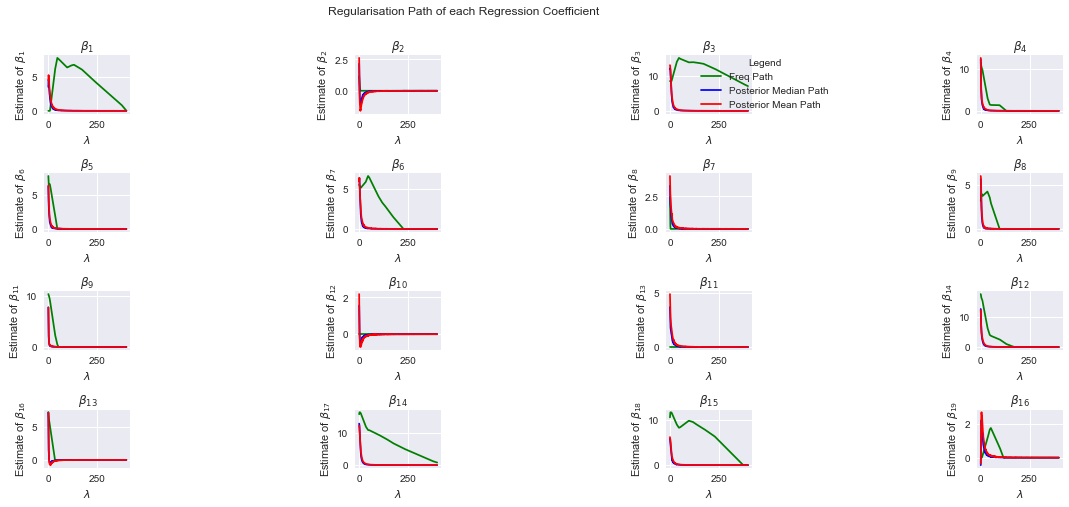

In [86]:
fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(15,7))
fig.suptitle("Regularisation Path of each Regression Coefficient",x=0.435,y=1.0)
for row in range(1,5):
    for column in range(1,5):
        ax[row-1][column-1].set_title(fr"$\beta_{{{4*(row-1)+column}}}$")
        ax[row-1][column-1].set_xlabel(r"$\lambda$")
        ax[row-1][column-1].set_ylabel(fr"Estimate of $\beta_{{{5*(row-1)+column}}}$")
        ax[row-1][column-1].plot(lambdas,freqLassoPath[:,4*(row-1)+column-1],color="g",label="Freq Path")
        ax[row-1][column-1].plot(lambdas,lambdaBetaMedians[:,4*(row-1)+column-1],color="b",label="Posterior Median Path")
        ax[row-1][column-1].plot(lambdas,lambdaBetaMeans[:,4*(row-1)+column-1],color="r",label="Posterior Mean Path")
        #if (3*(row-1)+column-1) >=3:
        #    ax[row-1][column-1].set_ylim(-0.1,0.1)
        #if ((row==1) and (column==2)):
        #    ax[row-1][column-1].set_xlim(0,300)
        #else:
        #    ax[row-1][column-1].set_xlim(0,150)
        if ((row==1) and (column==3)):
            ax[row-1][column-1].legend(loc="center right",title="Legend",bbox_to_anchor=(2, 0.5))
        
plt.tight_layout()
plt.show()

# Want to justify why lambda=400 in plots. 
# Wanted to see Beta2 go to zero, simulated dataset suggests strong correlation
# thats why it took longer to go to zero.

In [97]:
# (2) Regularisation paths as a function of relative L1 norm, for posterior median, lasso, ridge, posterior mean
lambdal1BetaMedians = np.linalg.norm(lambdaBetaMedians,1,axis=1)
relativel1BetaMedians = lambdal1BetaMedians/np.max(lambdal1BetaMedians)

lambdal1BetaMeans = np.linalg.norm(lambdaBetaMeans,1,axis=1)
relativel1BetaMeans = lambdal1BetaMeans/np.max(lambdal1BetaMeans)

lambdal1BetaModes = np.linalg.norm(freqLassoPath,1,axis=1)
relativel1BetaModes = lambdal1BetaModes/np.max(lambdal1BetaModes)

In [88]:
# Want to superimpose vertical lines for lambda chosen by MML for posterior summaries, lambda chosen by CV for lasso, ridge

In [89]:
# Find lambda for the frequentist lasso chosen by cross validation

lassoCVmodel = LassoCV(cv=3,fit_intercept=False,max_iter=10000,alphas=np.linspace(0.0005,10,1000))
lassoCVmodel.fit(X_train,np.ravel(y_train-np.mean(y_train)))

l1betaCV = np.linalg.norm(lassoCVmodel.coef_,1)
print("Smallest lambda tested in CV is:",min(lassoCVmodel.alphas_)*2*X_train.shape[0])
print("Largest lambda tested in CV is:",max(lassoCVmodel.alphas_)*2*X_train.shape[0])
print("Number of lambdas tested in CV is:", len(lassoCVmodel.alphas_))
print("Lambda chosen by cross-validation is:", lassoCVmodel.alpha_*2*X_train.shape[0])
print("L1 Norm of the betas with lambda chosen by CV is:", l1betaCV)

Smallest lambda tested in CV is: 0.013000000000000001
Largest lambda tested in CV is: 260.0
Number of lambdas tested in CV is: 1000
Lambda chosen by cross-validation is: 68.45802602602603
L1 Norm of the betas with lambda chosen by CV is: 54.62636923765712


In [90]:
# Calculate Ridge paths
ridgeLambdas = np.linspace(0.1,5000,200)
smRidge = sm.OLS(y_train-np.mean(y_train),X_train)
freqRidgePath = np.zeros((len(ridgeLambdas),16))
for idx in range(len(ridgeLambdas)):
    freqRidgePath[idx,:] = smRidge.fit_regularized(alpha=ridgeLambdas[idx]/(X_train.shape[0]),L1_wt=0).params
    
lambdal1BetaRidge = np.linalg.norm(freqRidgePath,1,axis=1)
relativel1BetaRidge = lambdal1BetaRidge/np.max(lambdal1BetaRidge)

# Find lambda for the frequentist ridge chosen by cross validation

ridgeCVmodel = RidgeCV(cv=3,fit_intercept=False,alphas=lassoCVmodel.alphas_*10)
ridgeCVmodel.fit(X_train,np.ravel(y_train-np.mean(y_train)))

l1betaridgeCV = np.linalg.norm(ridgeCVmodel.coef_,1)

In [91]:
# Find relative l1 norm of beta medians and means for lambdaMML
l1betamedianMML = np.linalg.norm(np.median(burnedbetatracesMML,axis=0),1)
l1betameanMML = np.linalg.norm(np.mean(burnedbetatracesMML,axis=0),1)

relativel1betamedianMML = l1betamedianMML/np.max(lambdal1BetaMedians)
relativel1betameanMML = l1betameanMML/np.max(lambdal1BetaMeans)

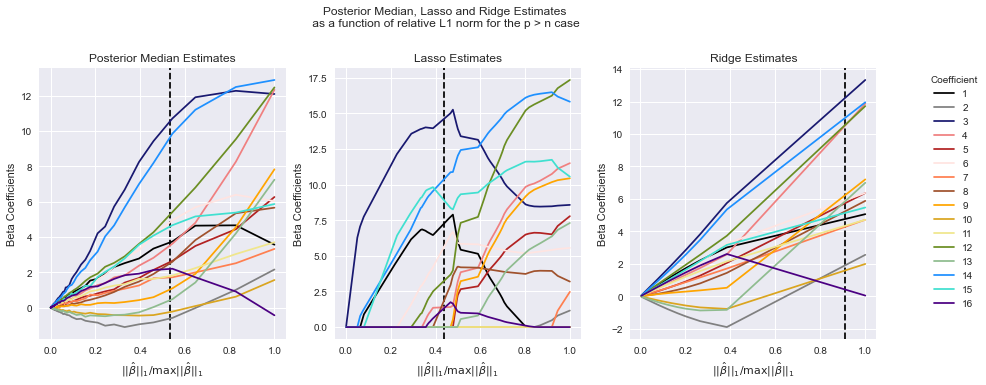

In [103]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15,5))
colors = ["black","gray","midnightblue","lightcoral","firebrick","mistyrose","coral", "sienna", "orange", "goldenrod", "khaki", "olivedrab", "darkseagreen", "dodgerblue", "turquoise", "indigo"]

# First plot Bayesian Lasso median estimates
ax[0].set_xlabel(r"$||\^{\beta}||_{1}/\max{||\^{\beta}||_{1}}$")
ax[0].set_ylabel("Beta Coefficients")
ax[0].set_title("Posterior Median Estimates")
for idx,color in enumerate(colors):
    ax[0].plot(relativel1BetaMedians,lambdaBetaMedians[:,idx],color=color,label=f"{idx+1}")
ax[0].set_ylim()
ax[0].vlines(relativel1betamedianMML,ax[0].get_ylim()[0],ax[0].get_ylim()[1],linestyle="--",colors="0")

# Now plot Lasso estimates
ax[1].set_xlabel(r"$||\^{\beta}||_{1}/\max{||\^{\beta}||_{1}}$")
ax[1].set_ylabel("Beta Coefficients")
ax[1].set_title("Lasso Estimates")

for idx,color in enumerate(colors):
    ax[1].plot(relativel1BetaModes,freqLassoPath[:,idx],color=color,label=f"{idx+1}")
ax[1].set_ylim()
ax[1].vlines(l1betaCV/np.max(lambdal1BetaModes),ax[1].get_ylim()[0],ax[1].get_ylim()[1],linestyle="--",colors="0")

# Now plot Ridge estimates
ax[2].set_xlabel(r"$||\^{\beta}||_{1}/\max{||\^{\beta}||_{1}}$")
ax[2].set_ylabel("Beta Coefficients")
ax[2].set_title("Ridge Estimates")

for idx,color in enumerate(colors):
    ax[2].plot(relativel1BetaRidge,freqRidgePath[:,idx],color=color,label=f"{idx+1}")
    if idx==15:
        handles, labels = ax[2].get_legend_handles_labels()
        fig.legend(handles, labels, loc='center right',title="Coefficient")    
ax[2].set_ylim()
ax[2].vlines(l1betaridgeCV/np.max(lambdal1BetaRidge),ax[2].get_ylim()[0],ax[2].get_ylim()[1],linestyle="--",colors="0")
fig.suptitle("Posterior Median, Lasso and Ridge Estimates\n as a function of relative L1 norm for the p > n case",y=1.05)
plt.show()

In [ ]:
# 